<a href="https://colab.research.google.com/github/mmaruthi/Assignment5/blob/master/ResNet50-Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [0]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


#from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50



Using TensorFlow backend.


In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()   # To Return the top 5 rows of the data frame 

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [0]:
df.describe()  # To get the summary of statistics

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
count,13573,13573,13573,13573,13573,13573,13573,13573,13573
unique,2,3,5,4,3,3,4,3,13573
top,male,Average,25-35,normal-healthy,None,Normal,Neutral,Front-Frontish,resized/2780.jpg
freq,7636,7509,5411,8628,7649,6038,9660,8383,1


In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True,augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
#       'items' is a df generated from main df based on batch_size. 
#       items.iterrows() will take item['image_path'] and fetch it to cv2.imread().
#       cv2.imread() will convert it to a numpy array which can be used by python
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        # target is a dictionary with all gender cols counted against key 'gender_output' and so on.
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
## Cut out 
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
# Creating Train and Validation data frames 
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
# Display top two rows from train and val data frames 
train_df.head(2)
val_df.head(2) 

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
4459,resized/4460.jpg,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1
9290,resized/9291.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32, 
                                augmentation=ImageDataGenerator(rescale=1./255,
                                                                featurewise_center=True,
                                                                featurewise_std_normalization=True,
                                                                horizontal_flip=True,
                                                                #width_shift_range=0.2,
                                                                #height_shift_range=0.2,
                                                                #fill_mode='nearest',
                                                                rotation_range=20,
                                                                preprocessing_function=get_random_eraser(v_l=1, v_h=1)))

valid_gen = PersonDataGenerator(val_df, batch_size=32, shuffle=False,
                                augmentation=ImageDataGenerator(rescale=1./255,
                                                                featurewise_center=True,
                                                                featurewise_std_normalization=True))

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
# targets is a dictionary that we get from person data generator.
# k will get key value 'age_output' which will be split to get 'age' only
# v will get value of disctionary. We will take how many columns are there in v to understand classes within each class. eg: v.shape[1] will be 2
# for key 'gender_output' because there are 2 sub-categories 'male' & 'female'
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

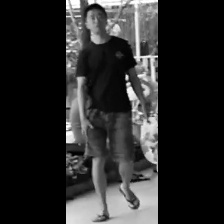

type:: <class 'numpy.ndarray'>


In [0]:
# To check if images are getting read correctly
from google.colab.patches import cv2_imshow
img = cv2.imread('resized/1.jpg',0)
cv2_imshow(img)
print('type::',type(img))

In [0]:
#Using ResNet50 with weights=None
backbone = ResNet50(
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output  #backbone.output gives the last layer already build by VGG16 on the above statement (block5_maxpool)
neck = Flatten(name="flattener")(neck)  # Adds Flatten layer
neck = Dense(512, activation="relu")(neck) # Adds fully connected layer with Relu Activation

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
def build_tower(in_layer):
    head = Dropout(0.3)(in_layer)
    head = Dense(256, activation="relu")(head)
    head = Dropout(0.3)(in_layer)
    head = Dense(256, activation="relu")(head)
    return head

def build_head(name, activator,in_layer):
    return Dense(
        num_units[name], activation=activator, name=f"{name}_output"
    )(in_layer)

In [0]:
# heads
# Calls build_tower function with layers till previous point i.e. in_layer
# For each multi-label class, build_tower adds to in_layer following - dropout -> fully connected layer -> droput -> fully connected layer &  
# returns back to build_head.
# Build_head applies a dense layer with softmax activation on top of this to give final output for that particular class. eg: gender, age etc.
# Model API will use one 'neck' and connect one ResNet50 with 8 'heads'(below) which are built using build_head & build_tower

gender = build_head("gender", "sigmoid", build_tower(neck))  #gender is binary classification
image_quality = build_head("image_quality", "sigmoid",build_tower(neck)) # image is multi-class single label, can be either good, avg or bad
age = build_head("age", "sigmoid",build_tower(neck))  # Age is regression to arbitrary value but here we are didving to groups like 15-25, 25-35, hence multi-class single label
weight = build_head("weight", "sigmoid",build_tower(neck)) # weight is multi-class, single label as it can healthy, over or under
bag = build_head("bag", "sigmoid",build_tower(neck))  # bag is multi-class, single label 
footwear = build_head("footwear","sigmoid", build_tower(neck))  # multi-class, single label 
emotion = build_head("emotion", "sigmoid", build_tower(neck))  # multi-class, single label 
pose = build_head("pose", "sigmoid",build_tower(neck)) # multi-class, single label 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

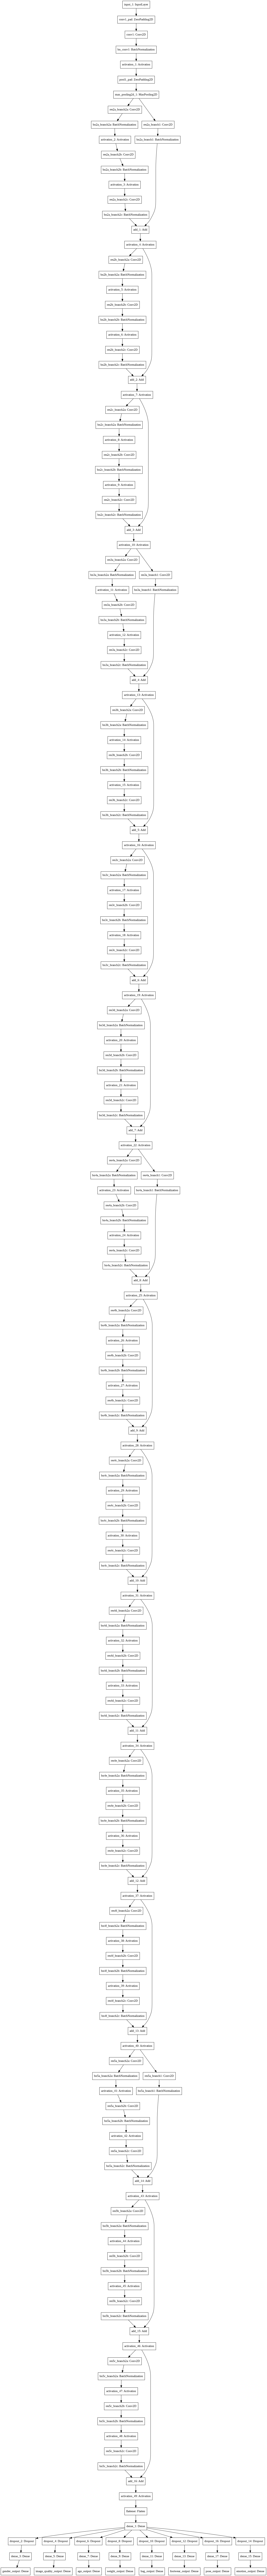

In [0]:
from keras.utils import plot_model
#plot_model(model, show_shapes=True,to_file='model.png')
plot_model(model)

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.004 * 1/(1 + 0.319 * epoch), 10)
opt = SGD(lr=0.003, momentum=0.9)
#opt = SGD(momentum=0.5)
model.compile(
    optimizer=opt,
    loss = "binary_crossentropy",
    metrics=["accuracy"]
)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=1, 
    epochs=150,
    verbose=1,
    callbacks=[LearningRateScheduler(scheduler,verbose=1)])



Epoch 1/150

Epoch 00001: LearningRateScheduler setting learning rate to 0.004.
360/360 [==============================] - 240s 666ms/step - loss: 4.8831 - gender_output_loss: 0.7901 - image_quality_output_loss: 0.6613 - age_output_loss: 0.5323 - weight_output_loss: 0.4948 - bag_output_loss: 0.6301 - footwear_output_loss: 0.7042 - pose_output_loss: 0.6101 - emotion_output_loss: 0.4603 - gender_output_acc: 0.5435 - image_quality_output_acc: 0.6885 - age_output_acc: 0.7921 - weight_output_acc: 0.8128 - bag_output_acc: 0.6957 - footwear_output_acc: 0.6537 - pose_output_acc: 0.7367 - emotion_output_acc: 0.8482 - val_loss: 4.2657 - val_gender_output_loss: 0.6876 - val_image_quality_output_loss: 0.5817 - val_age_output_loss: 0.4593 - val_weight_output_loss: 0.4369 - val_bag_output_loss: 0.5549 - val_footwear_output_loss: 0.6020 - val_pose_output_loss: 0.5559 - val_emotion_output_loss: 0.3873 - val_gender_output_acc: 0.5335 - val_image_quality_output_acc: 0.6786 - val_age_output_acc: 0.8000